# Customer Churn Prediction - Machine Learning Pipeline
## Customer Behavior & Revenue Intelligence System

**Project Goal:** Predict which customers are likely to churn (stop purchasing) based on their behavioral patterns.

**Model Used:** Logistic Regression

**Prerequisites:**
- PostgreSQL database with tables created (run `database_setup.sql` first)

---

## 1. Setup & Installation

In [71]:
# Install required packages
!pip install pandas psycopg2-binary scikit-learn matplotlib seaborn sqlalchemy python-dotenv joblib

In [72]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
import os
from datetime import datetime

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    roc_auc_score,
    roc_curve
)
import joblib

# Settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully")

All libraries imported successfully


## 2. Database Configuration

In [130]:
import psycopg2

conn = psycopg2.connect(
    dbname="customer_behavior_and_revenue_intelligence_system",
    user="postgres",
    password="xyz1234",
    host="localhost",
    port="5432"
)
print("Direct psycopg2 connection successful!")
conn.close()

Direct psycopg2 connection successful!


## 3. Load Data from Database

In [76]:
# Load ML features from the database
query = "SELECT * FROM customer_ml_features"

try:
    df = pd.read_sql(query, engine)
    print(f"Loaded {len(df):,} customer records")
    print(f"Features: {df.shape[1]} columns")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# Display first few rows
df.head()

Loaded 3,000 customer records
Features: 10 columns
Memory usage: 0.56 MB


,customer_id,age,gender,city,total_orders,total_spent,avg_order_value,last_order_date,days_since_last_order,churn
0,790,19,Male,Jaipur,7,72673.96,10381.99,2025-12-11,60.0,0
1,2850,18,Male,Pune,0,NaN,NaN,None,NaN,0
2,1798,29,Male,Kolkata,0,NaN,NaN,None,NaN,0
3,1489,28,Male,Pune,0,NaN,NaN,None,NaN,0
4,2335,29,Male,Delhi,0,NaN,NaN,None,NaN,0


## 4. Exploratory Data Analysis (EDA)

In [78]:
# Basic dataset information
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(df.info())
print("\n" + "=" * 60)
print("STATISTICAL SUMMARY")
print("=" * 60)
print(df.describe())

DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            3000 non-null   int64  
 1   age                    3000 non-null   int64  
 2   gender                 3000 non-null   object 
 3   city                   3000 non-null   object 
 4   total_orders           3000 non-null   int64  
 5   total_spent            1000 non-null   float64
 6   avg_order_value        1000 non-null   float64
 7   last_order_date        1000 non-null   object 
 8   days_since_last_order  1000 non-null   float64
 9   churn                  3000 non-null   int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 234.5+ KB
None

STATISTICAL SUMMARY
       customer_id          age  total_orders    total_spent  avg_order_value  \
count  3000.000000  3000.000000   3000.000000    1000.000000      1000.000000   


In [79]:
# Check for missing values
missing_data = df.isnull().sum()
missing_pct = 100 * df.isnull().sum() / len(df)
missing_table = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_pct
})

print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)
print(missing_table[missing_table['Missing Count'] > 0])

if missing_table['Missing Count'].sum() == 0:
    print("No missing values found!")
else:
    print(f"\n⚠ Total missing values: {missing_table['Missing Count'].sum()}")

MISSING VALUES ANALYSIS
                       Missing Count  Percentage
total_spent                     2000   66.666667
avg_order_value                 2000   66.666667
last_order_date                 2000   66.666667
days_since_last_order           2000   66.666667

⚠ Total missing values: 8000


TARGET VARIABLE: CHURN DISTRIBUTION
Not Churned (0): 2,865 (95.50%)
Churned (1):     135 (4.50%)


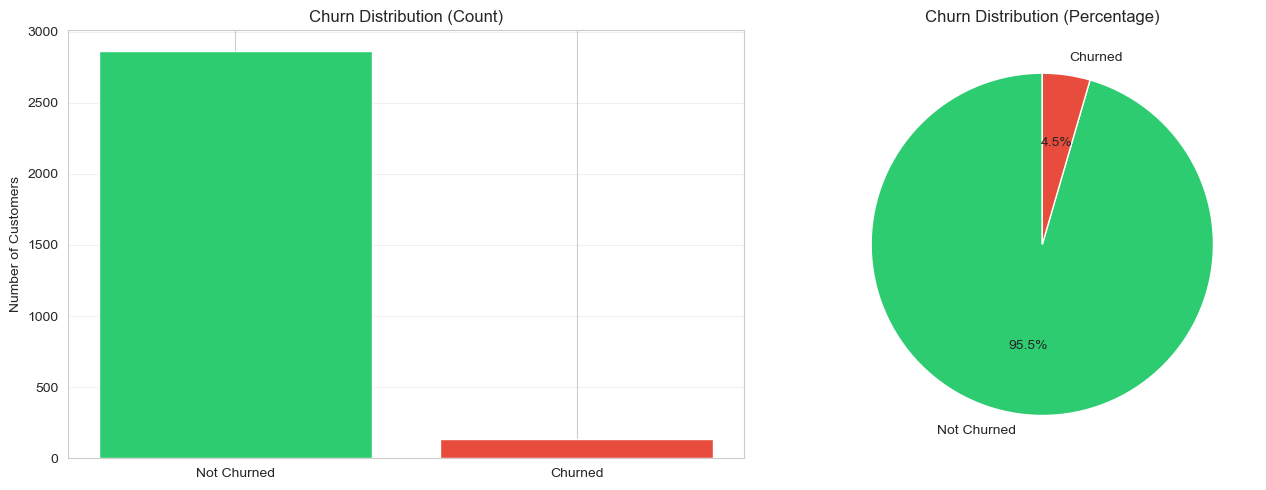

In [80]:
# Analyze target variable distribution
churn_dist = df['churn'].value_counts()
churn_pct = 100 * df['churn'].value_counts(normalize=True)

print("=" * 60)
print("TARGET VARIABLE: CHURN DISTRIBUTION")
print("=" * 60)
print(f"Not Churned (0): {churn_dist[0]:,} ({churn_pct[0]:.2f}%)")
print(f"Churned (1):     {churn_dist[1]:,} ({churn_pct[1]:.2f}%)")

# Visualize churn distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(['Not Churned', 'Churned'], churn_dist.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_ylabel('Number of Customers')
axes[0].set_title('Churn Distribution (Count)')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(churn_dist.values, labels=['Not Churned', 'Churned'], 
            autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Churn Distribution (Percentage)')

plt.tight_layout()
plt.show()

# Check for class imbalance
if min(churn_pct) < 30:
    print(f"\n WARNING: Class imbalance detected! Consider using SMOTE or class weights.")
else:
    print(f"\n Classes are reasonably balanced.")

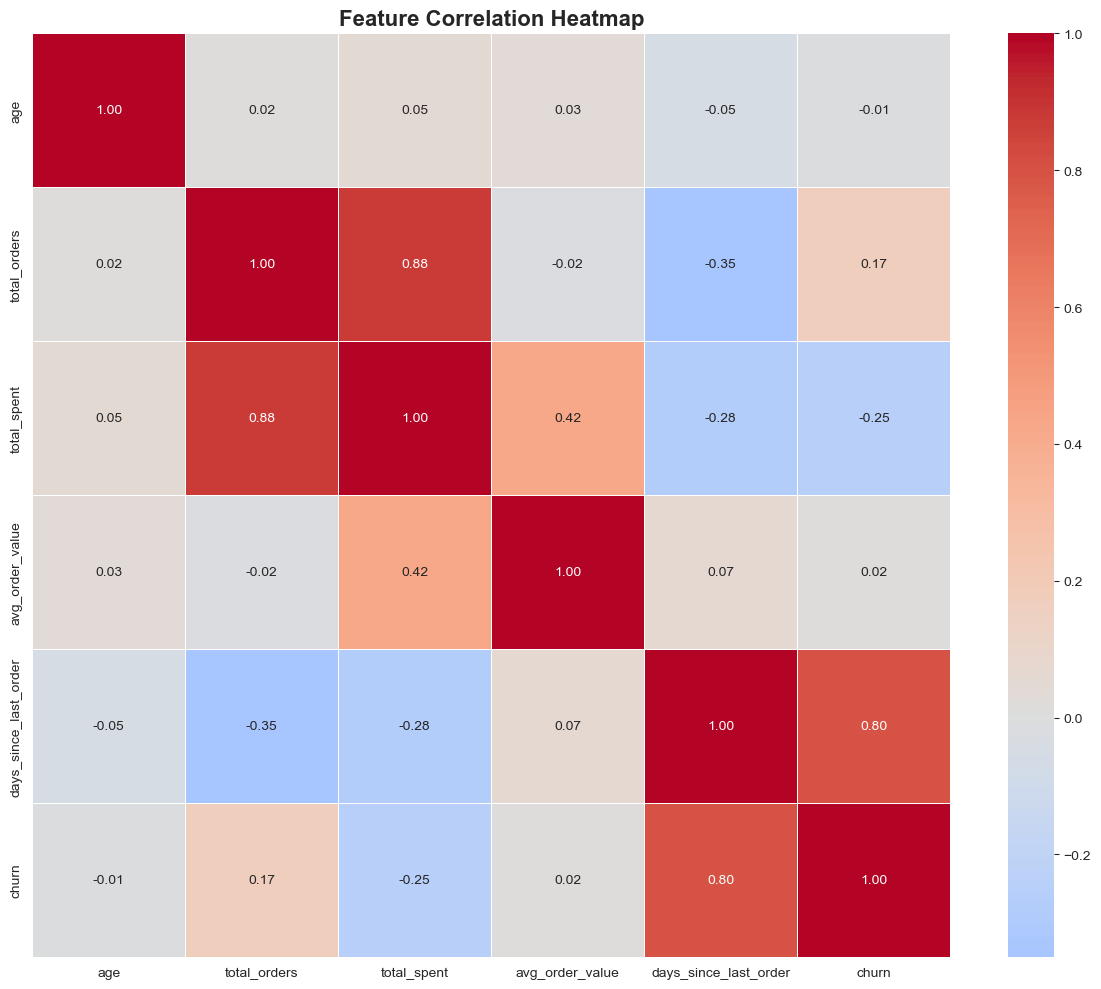

In [81]:
# Correlation analysis for numerical features
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col != 'customer_id']

plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Data Preprocessing

In [83]:
# Handle missing values properly
# Note: Since SQL already handles this with COALESCE, this is a safety check
print("Before handling missing values:")
print(df.isnull().sum())

# Fill numeric columns with 0 (representing no activity)
numeric_cols = ['total_orders', 'total_spent', 'avg_order_value', 'days_since_last_order']
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

print("\nAfter handling missing values:")
print(df.isnull().sum())
print("\nMissing values handled")

Before handling missing values:
customer_id                 0
age                         0
gender                      0
city                        0
total_orders                0
total_spent              2000
avg_order_value          2000
last_order_date          2000
days_since_last_order    2000
churn                       0
dtype: int64

After handling missing values:
customer_id                 0
age                         0
gender                      0
city                        0
total_orders                0
total_spent                 0
avg_order_value             0
last_order_date          2000
days_since_last_order       0
churn                       0
dtype: int64

Missing values handled


In [84]:
# Feature Engineering: One-hot encoding for categorical variables
print("Categorical variables to encode:")
categorical_cols = ['gender', 'city']
print(categorical_cols)

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

print(f"\nEncoded dataset shape: {df_encoded.shape}")
print(f"  Original features: {df.shape[1]}")
print(f"  After encoding: {df_encoded.shape[1]}")
print(f"  New features added: {df_encoded.shape[1] - df.shape[1]}")

Categorical variables to encode:
['gender', 'city']

Encoded dataset shape: (3000, 19)
  Original features: 10
  After encoding: 19
  New features added: 9


In [85]:
# Prepare features (X) and target (y)
# Exclude non-feature columns
exclude_cols = ['customer_id', 'churn', 'last_order_date']
feature_columns = [col for col in df_encoded.columns if col not in exclude_cols]

X = df_encoded[feature_columns]
y = df_encoded['churn']

print("=" * 60)
print("FEATURE SET SUMMARY")
print("=" * 60)
print(f"Total features: {X.shape[1]}")
print(f"Total samples: {X.shape[0]:,}")
print(f"\nFeature list:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nTarget variable:")
print(f"  - Churned: {y.sum():,} ({100*y.sum()/len(y):.2f}%)")
print(f"  - Active:  {len(y)-y.sum():,} ({100*(len(y)-y.sum())/len(y):.2f}%)")

FEATURE SET SUMMARY
Total features: 16
Total samples: 3,000

Feature list:
   1. age
   2. total_orders
   3. total_spent
   4. avg_order_value
   5. days_since_last_order
   6. gender_Female
   7. gender_Male
   8. gender_Other
   9. city_Bangalore
  10. city_Chennai
  11. city_Delhi
  12. city_Hyderabad
  13. city_Jaipur
  14. city_Kolkata
  15. city_Mumbai
  16. city_Pune

Target variable:
  - Churned: 135 (4.50%)
  - Active:  2,865 (95.50%)


## 6. Train-Test Split

In [87]:
# Split data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Maintain class distribution
)

print("=" * 60)
print("TRAIN-TEST SPLIT SUMMARY")
print("=" * 60)
print(f"Training set:   {X_train.shape[0]:,} samples ({100*X_train.shape[0]/X.shape[0]:.1f}%)")
print(f"Testing set:    {X_test.shape[0]:,} samples ({100*X_test.shape[0]/X.shape[0]:.1f}%)")
print(f"\nTraining set churn distribution:")
print(f"  - Churned: {y_train.sum():,} ({100*y_train.sum()/len(y_train):.2f}%)")
print(f"  - Active:  {len(y_train)-y_train.sum():,} ({100*(len(y_train)-y_train.sum())/len(y_train):.2f}%)")
print(f"\nTesting set churn distribution:")
print(f"  - Churned: {y_test.sum():,} ({100*y_test.sum()/len(y_test):.2f}%)")
print(f"  - Active:  {len(y_test)-y_test.sum():,} ({100*(len(y_test)-y_test.sum())/len(y_test):.2f}%)")
print("\n Data split complete with stratification")

TRAIN-TEST SPLIT SUMMARY
Training set:   2,100 samples (70.0%)
Testing set:    900 samples (30.0%)

Training set churn distribution:
  - Churned: 95 (4.52%)
  - Active:  2,005 (95.48%)

Testing set churn distribution:
  - Churned: 40 (4.44%)
  - Active:  860 (95.56%)

 Data split complete with stratification


## 7. Model Training

In [89]:
# Train Logistic Regression model
print("Training Logistic Regression model...")

model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

model.fit(X_train, y_train)

print(" Model training complete!")
print(f"  Iterations completed: {model.n_iter_[0]}")
print(f"  Convergence achieved: {model.n_iter_[0] < 1000}")

Training Logistic Regression model...
 Model training complete!
  Iterations completed: 1000
  Convergence achieved: False


## 8. Model Evaluation

In [91]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))

MODEL PERFORMANCE METRICS
Accuracy:  0.9944 (99.44%)
ROC-AUC:   0.9999

CONFUSION MATRIX
[[855   5]
 [  0  40]]

True Negatives:  855
False Positives: 5
False Negatives: 0
True Positives:  40

CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Not Churned       1.00      0.99      1.00       860
     Churned       0.89      1.00      0.94        40

    accuracy                           0.99       900
   macro avg       0.94      1.00      0.97       900
weighted avg       1.00      0.99      0.99       900



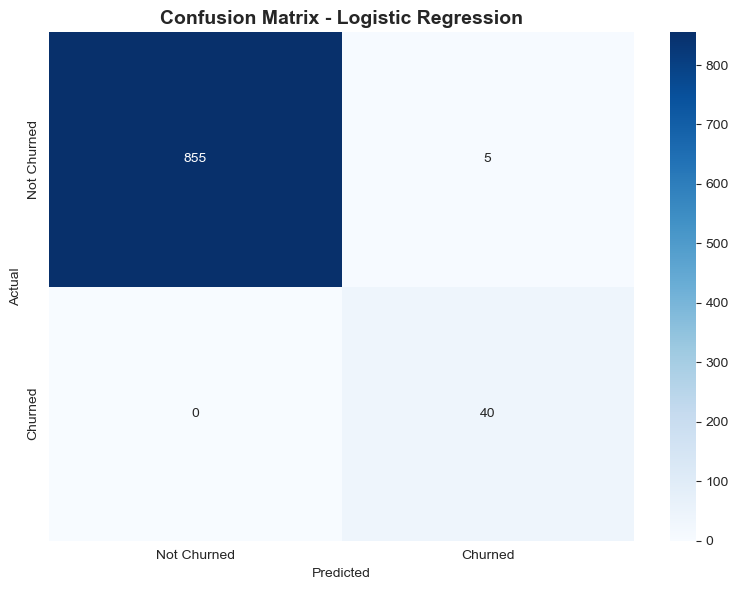

In [92]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

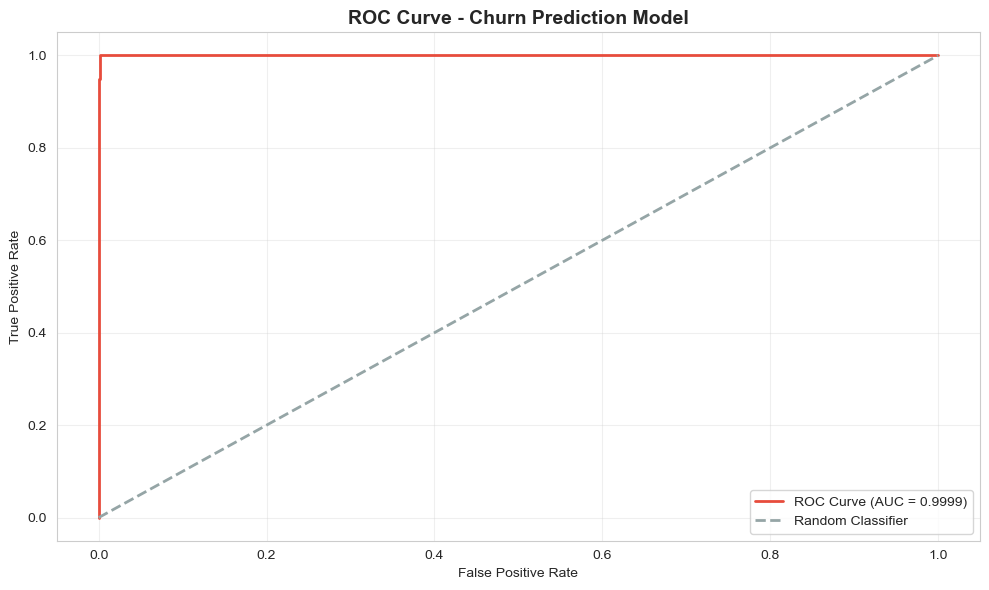

In [93]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='#e74c3c', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='#95a5a6', linewidth=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Churn Prediction Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Model Interpretation

FEATURE IMPORTANCE (Sorted by Coefficient)
              feature  coefficient
       city_Bangalore     0.696793
days_since_last_order     0.334937
         city_Chennai     0.308647
       city_Hyderabad     0.240355
          total_spent     0.000204
      avg_order_value    -0.001758
                  age    -0.013408
         gender_Other    -0.615861
          city_Jaipur    -0.705001
         city_Kolkata    -0.805157
          city_Mumbai    -0.821895
           city_Delhi    -1.016657
        gender_Female    -1.227282
            city_Pune    -1.353621
          gender_Male    -1.613393
         total_orders    -2.303834


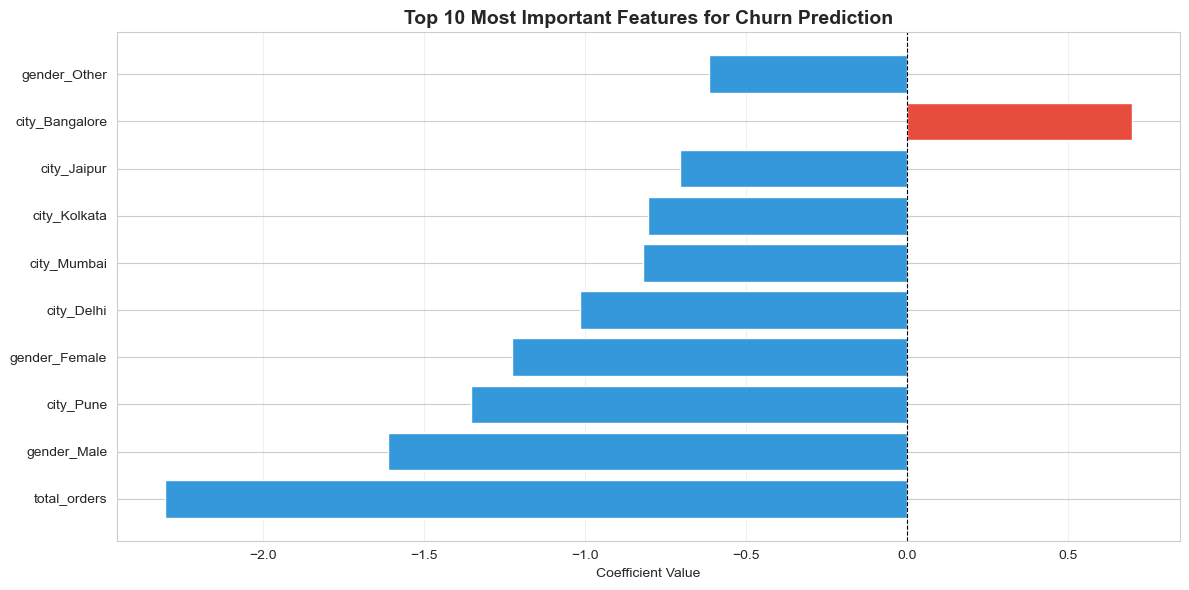


 Interpretation:
  + Positive coefficient = Increases churn probability
  - Negative coefficient = Decreases churn probability


In [98]:
# Feature importance from coefficients
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0],
    'abs_coefficient': np.abs(model.coef_[0])
}).sort_values(by='coefficient', ascending=False)

print("=" * 60)
print("FEATURE IMPORTANCE (Sorted by Coefficient)")
print("=" * 60)
print(feature_importance[['feature', 'coefficient']].to_string(index=False))

# Show top 10 most important features
top_features = feature_importance.nlargest(10, 'abs_coefficient')

plt.figure(figsize=(12, 6))
colors = ['#e74c3c' if x > 0 else '#3498db' for x in top_features['coefficient']]
plt.barh(top_features['feature'], top_features['coefficient'], color=colors)
plt.xlabel('Coefficient Value')
plt.title('Top 10 Most Important Features for Churn Prediction', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Interpretation:")
print("  + Positive coefficient = Increases churn probability")
print("  - Negative coefficient = Decreases churn probability")

## 10. Model Comparison

COMPARING MULTIPLE MODELS

Training Logistic Regression...
  Accuracy: 0.9944, ROC-AUC: 0.9999

Training Random Forest...
  Accuracy: 1.0000, ROC-AUC: 1.0000

Training Decision Tree...
  Accuracy: 1.0000, ROC-AUC: 1.0000

MODEL COMPARISON SUMMARY
              Model  Accuracy  ROC-AUC
      Random Forest  1.000000 1.000000
      Decision Tree  1.000000 1.000000
Logistic Regression  0.994444 0.999942


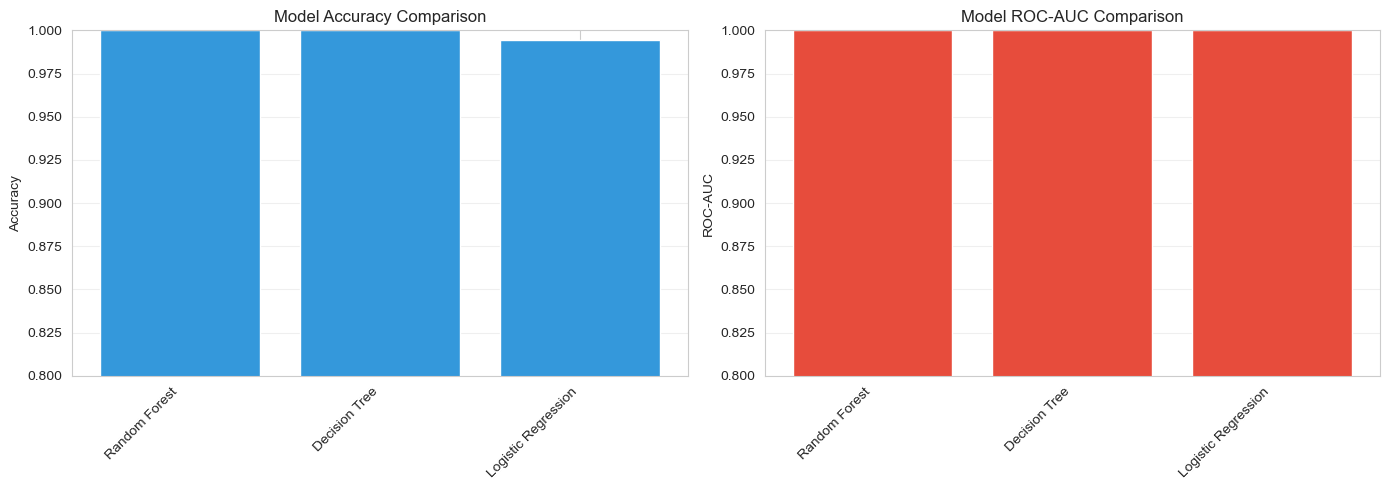

In [103]:
# Compare multiple models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced')
}

results = []

print("=" * 60)
print("COMPARING MULTIPLE MODELS")
print("=" * 60)

for name, mdl in models.items():
    print(f"\nTraining {name}...")
    mdl.fit(X_train, y_train)
    
    y_pred_temp = mdl.predict(X_test)
    y_proba_temp = mdl.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred_temp)
    auc = roc_auc_score(y_test, y_proba_temp)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'ROC-AUC': auc
    })
    
    print(f"  Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}")

# Display comparison
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(results_df['Model'], results_df['Accuracy'], color='#3498db')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylim([0.8, 1.0])
axes[0].grid(axis='y', alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

axes[1].bar(results_df['Model'], results_df['ROC-AUC'], color='#e74c3c')
axes[1].set_ylabel('ROC-AUC')
axes[1].set_title('Model ROC-AUC Comparison')
axes[1].set_ylim([0.8, 1.0])
axes[1].grid(axis='y', alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 11. Save Predictions to Database

In [106]:
# Generate predictions for ALL customers
all_predictions = model.predict(X)
all_probabilities = model.predict_proba(X)[:, 1]

# Create predictions dataframe
predictions_df = pd.DataFrame({
    'customer_id': df['customer_id'],
    'churn_prediction': all_predictions,
    'churn_probability': all_probabilities.round(4)
})

print("=" * 60)
print("PREDICTION SUMMARY")
print("=" * 60)
print(f"Total predictions: {len(predictions_df):,}")
print(f"\nPredicted churn distribution:")
print(predictions_df['churn_prediction'].value_counts())
print(f"\nChurn rate: {100 * predictions_df['churn_prediction'].mean():.2f}%")

# Display sample predictions
print("\nSample predictions (high churn probability):")
print(predictions_df.nlargest(10, 'churn_probability'))

PREDICTION SUMMARY
Total predictions: 3,000

Predicted churn distribution:
churn_prediction
0    2844
1     156
Name: count, dtype: int64

Churn rate: 5.20%

Sample predictions (high churn probability):
     customer_id  churn_prediction  churn_probability
56           161                 1                1.0
80           644                 1                1.0
132            2                 1                1.0
153          355                 1                1.0
160          222                 1                1.0
267           74                 1                1.0
293          526                 1                1.0
297          524                 1                1.0
317          360                 1                1.0
338           12                 1                1.0


In [107]:
# Save predictions to database
try:
    rows_inserted = predictions_df.to_sql(
        'customer_churn_predictions',
        engine,
        if_exists='replace',  # Replace existing table
        index=False,
        method='multi'  # Faster bulk insert
    )
    
    print("\n" + "=" * 60)
    print("DATABASE WRITE SUCCESSFUL")
    print("=" * 60)
    print(f" Saved {rows_inserted:,} predictions to 'customer_churn_predictions' table")
    print(f"  Table: customer_churn_predictions")
    print(f"  Columns: customer_id, churn_prediction, churn_probability")
    
except Exception as e:
    print(f"\n Error saving predictions to database: {e}")
    raise


DATABASE WRITE SUCCESSFUL
 Saved 3,000 predictions to 'customer_churn_predictions' table
  Table: customer_churn_predictions
  Columns: customer_id, churn_prediction, churn_probability


In [108]:
# Verify data was saved correctly
verification_query = """
SELECT 
    COUNT(*) as total_records,
    SUM(CASE WHEN churn_prediction = 1 THEN 1 ELSE 0 END) as churned_customers,
    ROUND(100.0 * SUM(CASE WHEN churn_prediction = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) as churn_rate_pct
FROM customer_churn_predictions
"""

try:
    verification = pd.read_sql(verification_query, engine)
    print("\n" + "=" * 60)
    print("DATABASE VERIFICATION")
    print("=" * 60)
    print(verification.to_string(index=False))
    print("\n Predictions successfully verified in database!")
except Exception as e:
    print(f"\n Error verifying database: {e}")


DATABASE VERIFICATION
 total_records  churned_customers  churn_rate_pct
          3000                156             5.2

 Predictions successfully verified in database!


## 12. Save Model & Metadata

In [110]:
# Save the trained model to disk
model_filename = 'churn_prediction_model.pkl'

try:
    joblib.dump(model, model_filename)
    print(f" Model saved to '{model_filename}'")
    print(f"  File size: {os.path.getsize(model_filename) / 1024:.2f} KB")
except Exception as e:
    print(f" Error saving model: {e}")

# Test loading the model
try:
    loaded_model = joblib.load(model_filename)
    print(f" Model loaded successfully from disk")
    print(f"  Model type: {type(loaded_model).__name__}")
except Exception as e:
    print(f" Error loading model: {e}")

 Model saved to 'churn_prediction_model.pkl'
  File size: 1.56 KB
 Model loaded successfully from disk
  Model type: LogisticRegression


In [114]:
# Save model metadata to database
from sklearn.metrics import precision_score, recall_score, f1_score

metadata = pd.DataFrame([{
    'model_name': 'Logistic Regression',
    'accuracy': round(accuracy, 4),
    'precision_score': round(precision_score(y_test, y_pred), 4),
    'recall_score': round(recall_score(y_test, y_pred), 4),
    'f1_score': round(f1_score(y_test, y_pred), 4),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'notes': f'ROC-AUC: {roc_auc:.4f}, Features: {X.shape[1]}'
}])

try:
    metadata.to_sql(
        'model_metadata',
        engine,
        if_exists='append',
        index=False
    )
    print(" Model metadata saved to database")
    print("\nMetadata:")
    print(metadata.T)
except Exception as e:
    print(f" Error saving metadata: {e}")

 Model metadata saved to database

Metadata:
                                              0
model_name                  Logistic Regression
accuracy                                 0.9944
precision_score                          0.8889
recall_score                                1.0
f1_score                                 0.9412
training_samples                           2100
test_samples                                900
notes             ROC-AUC: 0.9999, Features: 16
